<h1>Exploring and training some Machine models on the Mnist dataset</h1>

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Loading dataset and printing the description
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
print(dir(mnist))

['DESCR', 'categories', 'data', 'details', 'feature_names', 'frame', 'target', 'target_names', 'url']


In [4]:
#Splitting the data to X and y
X = mnist['data']
y = mnist['target'].astype(np.uint8)

In [5]:
#Splitting the data into training, validation and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

In [6]:
# Creating a medium large dataset from the trainingset to be able to train the model on some more data. 
#Only splitting into train.

X_train_medium, _, y_train_medium, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)

In [7]:
# Creating a smaller dataset from the trainingset to quickly test certain models, 
# such as SVM, which can be slow on the full dataset.
#Only splitting into train.

X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=3000, stratify=y_train, random_state=42)


<h2>EDA</h2>

In [8]:
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

In [10]:
df_mnist = pd.DataFrame(X_train)

In [11]:
df_mnist['target'] = y_train

In [12]:
#Counting the number of non-null values in each column
df_mnist.count()

0         50000
1         50000
2         50000
3         50000
4         50000
          ...  
780       50000
781       50000
782       50000
783       50000
target    50000
Length: 785, dtype: int64

In [13]:
df_mnist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 785 entries, 0 to target
dtypes: int64(784), uint8(1)
memory usage: 299.1 MB


In [14]:
#Sum of all nan-values
df_mnist.isna().sum()

0         0
1         0
2         0
3         0
4         0
         ..
780       0
781       0
782       0
783       0
target    0
Length: 785, dtype: int64

In [15]:
df_mnist.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.0,50000.0,50000.0,50000.0,50000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.096580,0.04014,0.017260,0.01306,0.001240,0.0,0.0,0.0,0.0,4.454660
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.118897,2.58817,1.685615,1.44559,0.277272,0.0,0.0,0.0,0.0,2.886547
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,2.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,7.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.00000,253.000000,244.00000,62.000000,0.0,0.0,0.0,0.0,9.000000


In [16]:
#Counting how many time each digit is represented.
df_mnist['target'].value_counts()

target
1    5567
7    5168
3    5079
2    5016
6    4970
9    4966
4    4952
0    4923
8    4868
5    4491
Name: count, dtype: int64

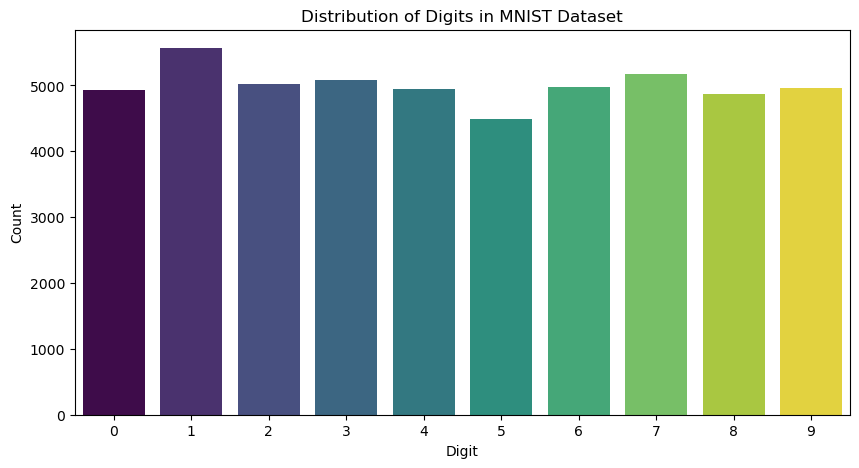

In [17]:
# Calculating each digit
digit_counts = df_mnist['target'].value_counts().sort_index()

# Creating barplot
plt.figure(figsize=(10, 5))
sns.barplot(x=digit_counts.index, y=digit_counts.values, hue=digit_counts.index, palette="viridis", legend=False)

plt.title("Distribution of Digits in MNIST Dataset")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.show()


In [18]:
# Checking the distribution in the original split.
distr_y_train = (np.bincount(y_train) / len(y_train))

# Checking the distribution in the smaller split.
distr_y_train_small = (np.bincount(y_train_small)) / len(y_train_small)

In [19]:
print(distr_y_train)
print(distr_y_train_small)

[0.09846 0.11134 0.10032 0.10158 0.09904 0.08982 0.0994  0.10336 0.09736
 0.09932]
[0.09833333 0.11133333 0.10033333 0.10166667 0.099      0.09
 0.09933333 0.10333333 0.09733333 0.09933333]


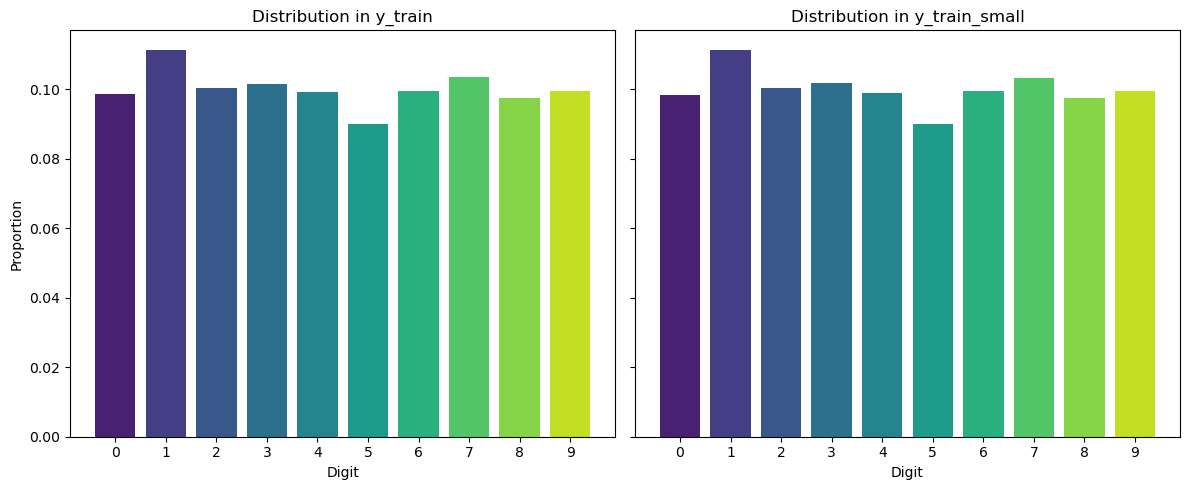

In [20]:
colors = sns.color_palette("viridis", 10)

# Creating two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plotting y_train-distribution
axes[0].bar(range(10), distr_y_train, color=colors)
axes[0].set_title("Distribution in y_train")
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("Proportion")
axes[0].set_xticks(range(10))

# Plotting y_train_small-distribution
axes[1].bar(range(10), distr_y_train_small, color=colors)
axes[1].set_title("Distribution in y_train_small")
axes[1].set_xlabel("Digit")
axes[1].set_xticks(range(10))

plt.tight_layout()
plt.show()

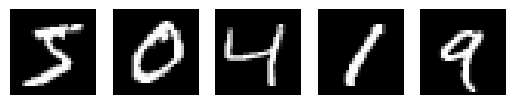

In [21]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(mnist.data[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

<h2>Preprocessing data </h2h>

In [8]:
#In order for some models to perform we first need to scale the data.
#Using StandardScaler to do that.
scaler = StandardScaler()

# Standardising the different datasets
X_small_scaled = scaler.fit_transform(X_train_small)
X_medium_scaled = scaler.fit_transform(X_train_medium)
X_large_scaled = scaler.fit_transform(X_train)

# Transforming the validation and testda
X_val_large_scaled = scaler.transform(X_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_large_scaled = scaler.transform(X_test)


<h2>Modeling</h2>

In [22]:
#Trying some models on the smaller dataset to see how they perform.
#If they perform well we can have them train on the larger set.
#Models i decided to test is:RidgeClassifier, SGDClassifier, SVM, DecisionTree, RandomForest


<h3>Training models on the small dataset</h3>

<h3>First run</h3>

In [23]:
#Preparing models
models = [
    ('SVC', SVC()),
    ('LogisticRegression', LogisticRegression()),
    ('SGDClassifier', SGDClassifier()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
]

# Preparing results
results = []

# Creating a loop for each model
for name, model in models:
    # Measuring startime
    start_time = time.time()
    
    # Cross validation
    cv_scores = cross_val_score(model, X_small_scaled, y_train_small, cv=5)
    
    # Measuring endtime and calculating the difference
    end_time = time.time()
    duration = end_time - start_time
    
    # Saving results
    results.append((name, cv_scores.mean(), duration))

# Printing results
for result in results:
    print(f"Model: {result[0]}")
    print(f"Mean CV Score: {result[1]:.4f}")
    print(f"Time taken: {result[2]:.2f} seconds\n")

Model: SVC
Mean CV Score: 0.9087
Time taken: 4.16 seconds

Model: LogisticRegression
Mean CV Score: 0.8757
Time taken: 0.93 seconds

Model: SGDClassifier
Mean CV Score: 0.8737
Time taken: 3.80 seconds

Model: DecisionTree
Mean CV Score: 0.7300
Time taken: 1.23 seconds

Model: RandomForest
Mean CV Score: 0.9267
Time taken: 3.81 seconds



In [24]:
small_results = pd.DataFrame(results, columns=['Model', 'Mean CV Score', 'Time Taken']).sort_values('Mean CV Score', ascending=False)
print(small_results)

                Model  Mean CV Score  Time Taken
4        RandomForest       0.926667    3.806844
0                 SVC       0.908667    4.156310
1  LogisticRegression       0.875667    0.933862
2       SGDClassifier       0.873667    3.799834
3        DecisionTree       0.730000    1.230171


<h3>Second run</h3>

In [38]:
# #Preparing models and hyperparams.
models = [
    ('SVC', SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }),
    ('LogisticRegression', LogisticRegression(), {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga']
    }),
    ('SGDClassifier', SGDClassifier(), {
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l2', 'elasticnet'],
        'learning_rate': ['constant', 'optimal'],
        'max_iter': [1000, 5000]
    }),
    ('DecisionTree', DecisionTreeClassifier(), {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'criterion': ['gini', 'entropy']
    }),
    ('RandomForest', RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    })
]

# Preparing results
results = []

# Running each model and their GridSearchh
for name, model, param_grid in models:
    start_time = time.time()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_medium_scaled, y_train_medium)
    elapsed_time = time.time() - start_time
    results.append((name, grid_search.best_params_, grid_search.best_score_, elapsed_time))

# Printing results
for result in results:
    print(f"Model: {result[0]}")
    print(f"Best Parameters: {result[1]}")
    print(f"Best CV Score: {result[2]:.4f}")
    print(f"Time taken: {result[3]:.2f} seconds\n")


c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter 

Model: SVC
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Score: 0.9482
Time taken: 345.42 seconds

Model: LogisticRegression
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best CV Score: 0.9095
Time taken: 1016.30 seconds

Model: SGDClassifier
Best Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'max_iter': 1000, 'penalty': 'l2'}
Best CV Score: 0.9011
Time taken: 1130.23 seconds

Model: DecisionTree
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.8064
Time taken: 115.68 seconds

Model: RandomForest
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.9496
Time taken: 561.94 seconds



Due to the warning messages and the uncertainty if the models might have performed better i will rerun each model again but this time one model at a time so i can adjust some settings if needed.

<h3>Running each model one by one (3rd run)</h3>

In [ ]:
#SVC
svc_clf = SVC()
svc_param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
        }
svc_gridsearch = GridSearchCV(svc_clf, svc_param_grid, scoring='accuracy', cv=5)
svc_gridsearch.fit(X_medium_scaled, y_train_medium)
print(svc_gridsearch.best_score_)

0.9481999999999999


In [27]:
print(svc_gridsearch.best_params_)
print(svc_gridsearch.best_estimator_)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVC(C=10, gamma='auto')


In [33]:
#Saving the model under a different name
#The model was saved before the computer was turned of. So instead of running the code above again
#to hade this code work i instead load the model below in the code.
#svm_clf = svc_gridsearch

In [23]:
#LogisticRegression
log_clf = LogisticRegression(max_iter=500)
log_param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga', 'lbfgs']
        }
log_gridsearch = GridSearchCV(log_clf, log_param_grid, scoring='accuracy', cv=5)
log_gridsearch.fit(X_medium_scaled, y_train_medium)
print(log_gridsearch.best_score_)
print(log_gridsearch.best_params_)
print(log_gridsearch.best_estimator_)

c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter 

0.9064
{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=0.1, max_iter=500, solver='saga')


c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
logreg_clf = log_gridsearch

In [24]:
#SGDClassifier
sgd_clf = SGDClassifier()
sgd_param_grid = {
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l2', 'elasticnet'],
        'learning_rate': ['constant', 'optimal'],
        'max_iter': [1000, 5000]
    }
sgd_gridsearch = GridSearchCV(sgd_clf, sgd_param_grid, scoring='accuracy', cv=5)
sgd_gridsearch.fit(X_medium_scaled, y_train_medium)
print(sgd_gridsearch.best_score_)
print(sgd_gridsearch.best_params_)
print(sgd_gridsearch.best_estimator_)

c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\model_sel

0.9015000000000001
{'alpha': 0.0001, 'learning_rate': 'optimal', 'max_iter': 1000, 'penalty': 'l2'}
SGDClassifier()


c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [29]:
#DecisionTree
dtree_clf = DecisionTreeClassifier()
dtree_param_grid = {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'criterion': ['gini', 'entropy']
    }
dtree_gridsearch = GridSearchCV(dtree_clf, dtree_param_grid, scoring='accuracy', cv=5)
dtree_gridsearch.fit(X_medium_scaled, y_train_medium)
print(dtree_gridsearch.best_score_)
print(dtree_gridsearch.best_params_)
print(dtree_gridsearch.best_estimator_)

0.8069
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=10)


In [30]:
#RandomForest
rf_clf = RandomForestClassifier()
rf_param_grid =  {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
rf_gridsearch = GridSearchCV(rf_clf, rf_param_grid, scoring='accuracy', cv=5)
rf_gridsearch.fit(X_medium_scaled, y_train_medium)
print(rf_gridsearch.best_score_)
print(rf_gridsearch.best_params_)
print(rf_gridsearch.best_estimator_)


0.9486000000000001
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier(max_depth=20, n_estimators=200)


In [37]:
rf_model.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

<h3>Adding anoter model, ExtraTree to see if it can perform well on the data</h3>

In [ ]:
et_clf = ExtraTreesClassifier()
et_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True]
}
etree_clf = GridSearchCV(et_clf, et_param_grid, scoring='accuracy', cv=5)

etree_clf.fit(X_medium_scaled, y_train_medium)

best_et_model = ExtraTreesClassifier(**etree_clf.best_params_, random_state=42)
best_et_model.fit(X_large_scaled, y_train)


print(etree_clf.best_score_)
print(etree_clf.best_params_)
print(etree_clf.best_estimator_)


c:\Users\nexuz\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.9561999999999999
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
ExtraTreesClassifier(max_depth=20, n_estimators=500)


In [ ]:
#Testing saving a model
joblib.dump(svm_clf, 'models/temp/my_svc_20250311')

['my_svc_20250311']

In [ ]:
#Also saving the RF_model
rf_model = rf_gridsearch
joblib.dump(rf_gridsearch, 'models/temp/my_rf_model20250311')

['my_rf_model20250311']

In [ ]:
#Saving model ExtraTree
joblib.dump(etree_clf, 'models/temp/extra_tree_20250311')

['extra_tree_20250311']

In [ ]:
#Saving LogReg_model
joblib.dump(log_gridsearch, 'models/temp/log_reg_model_20250312')

['log_reg_model_20250312']

In [ ]:
#Saving SGDClf
joblib.dump(sgd_gridsearch, 'models/temp/sgld_cclf_20250312')

['sgld_cclf_20250312']

In [ ]:
#Loading RfMoodel to get scoore.
rf_clf = joblib.load('models/temp/my_rf_model20250311')

In [ ]:
#Loading ExtraTree to get scoore.
et_clf = joblib.load('models/temp/extra_tree_20250311')

In [ ]:
svm_clf = joblib.load('models/temp/my_svc_20250311')

In [ ]:
#Loading LogisticReg model
lr_clf = joblib.load('models/temp/log_reg_model_20250312')

In [41]:
#Saving the new scores
new_results = []
new_results.append({"Model": "SVM", "Best Accuracy": svm_clf.best_score_})
new_results.append({"Model": "Logistic Regression", "Best Accuracy": log_gridsearch.best_score_})
new_results.append({"Model": "SGDClassifier", "Best Accuracy": sgd_gridsearch.best_score_})
new_results.append({"Model": "DecisionTree", "Best Accuracy": 0.8069})
new_results.append({"Model": "RandomForest", "Best Accuracy": rf_clf.best_score_})
new_results.append({"Model": "ExtraTrees", "Best Accuracy": et_clf.best_score_})

In [44]:
results_eachmodel = pd.DataFrame(new_results)
print(results_eachmodel.sort_values(by='Best Accuracy', ascending=False))

                 Model  Best Accuracy
5           ExtraTrees         0.9562
4         RandomForest         0.9486
0                  SVM         0.9482
1  Logistic Regression         0.9064
2        SGDClassifier         0.9015
3         DecisionTree         0.8069


<h2>Picking top 4 models. Training on whole X_train and validation on X_val</h2>

In [ ]:
#Training model on X_train and validation on X_val
best_et_model = ExtraTreesClassifier(**et_clf.best_params_, random_state=42)
best_et_model.fit(X_large_scaled, y_train)
best_et_y_predict = best_et_model.predict(X_val_large_scaled)
best_et_accuracy_score = accuracy_score(y_val, best_et_y_predict)
print(best_et_accuracy_score)
joblib.dump(best_et_model, 'models/validation/my_best_et_model.joblib')

0.9719


['my_best_et_model.joblib']

In [ ]:
#Training RandomForest model on X_train and validation on X_val
best_rf_model = RandomForestClassifier(**rf_clf.best_params_, random_state=42)
best_rf_model.fit(X_large_scaled, y_train)
best_rf_y_predict = best_rf_model.predict(X_val_large_scaled)
best_rf_accuracy_score = accuracy_score(y_val, best_rf_y_predict)
print(best_rf_accuracy_score)
joblib.dump(best_rf_model, 'models/validation/my_best_rf_model.joblib')

0.97


['my_best_rf_model.joblib']

In [ ]:
#Training the SVC model on the whole X_train and validation on X_val
best_svc_model = SVC(**svm_clf.best_params_, random_state=42)
best_svc_model.fit(X_large_scaled, y_train)
best_svc_y_predict = best_svc_model.predict(X_val_large_scaled)
best_svc_accuracy_score = accuracy_score(y_val, best_svc_y_predict)
print(best_svc_accuracy_score)
joblib.dump(best_svc_model, 'models/validation/my_best_svc_model.joblib')

0.9715


['my_best_svc_model.joblib']

In [ ]:
#Training the LogisticReg model on the whole X_train and validation on X_val
best_lr_model = LogisticRegression(**lr_clf.best_params_, random_state=42)
best_lr_model.fit(X_large_scaled, y_train)
best_lr_y_predict = best_lr_model.predict(X_val_large_scaled)
best_lr_accuracy_score = accuracy_score(y_val, best_lr_y_predict)
print(best_lr_accuracy_score)
joblib.dump(best_lr_model, 'models/validation/my_best_lr_model.joblib')

0.9169


c:\Users\nexuz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['my_best_lr_model.joblib']

<h2>Will a model with no tuned hyperparams perform as well or even better than a model that is tuned?</h2>
To find out, let us just create some models and let us put them inside a voting classifier to see if the collective can perform even better.

In [11]:
random_forest_clf = RandomForestClassifier(random_state=42)
random_forest_clf.fit(X_large_scaled, y_train)
rf_sccore = random_forest_clf.score(X_val_large_scaled, y_val)
rf_sccore

0.9692

In [12]:
extra_tree_clf = ExtraTreesClassifier(random_state=42)
extra_tree_clf.fit(X_large_scaled, y_train)
ex_tree_score = extra_tree_clf.score(X_val_large_scaled, y_val)
ex_tree_score

0.9715

In [13]:
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_large_scaled, y_train)
svm_clf_score = svm_clf.score(X_val_large_scaled, y_val)
svm_clf_score

0.9632

<h3>Creating the hard and soft VotingClassifiers</h3>

In [14]:
#Creating the models
named_estimators = [
    ('random_forest_clf', random_forest_clf),
    ('extra_tree_clf', extra_tree_clf),
    ('svm_clf', svm_clf)
]
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_large_scaled, y_train)
score_voting_clf = voting_clf.score(X_val_large_scaled, y_val)
score_voting_clf

0.9731

In [16]:
#Creating another voting with soft voting
voting_clf_soft = VotingClassifier(named_estimators, voting='soft')
voting_clf_soft .fit(X_large_scaled, y_train)
score_voting_clf_soft  = voting_clf_soft.score(X_val_large_scaled, y_val)
score_voting_clf_soft

0.9754

In [17]:
#Saving models if i need them and also to check the sizes.

#RF no grid
joblib.dump(random_forest_clf, 'models/validation/rf_no_grid.joblib')
#Extree no grid
joblib.dump(extra_tree_clf, 'models/validation/ext_no_grid.joblib')
#SVC no grid, prob
joblib.dump(svm_clf, 'models/validation/svc_no_grid_prob_y.joblib')
#Hard voting_clf
joblib.dump(voting_clf, 'models/validation/voting_hard.joblib')
#Soft voting_clf
joblib.dump(voting_clf_soft, 'models/validation/voting_soft.joblib')

['models/validation/voting_soft.joblib']

<h2>Picking the VotingClassifier (voting='soft') as the winner. <br>Will predict on X_test to see its accuracy</h2>

In [11]:
voting_clf_soft = joblib.load('models/validation/voting_soft.joblib')

In [12]:
#First i retrain the model with all availabe data on X_train and X_val
voting_clf_soft.fit(X_train_val_scaled, y_train_val)
score_voting_clf_soft_full  = voting_clf_soft.score(X_train_val_scaled, y_train_val)
print(score_voting_clf_soft_full)

1.0


Visualising results in a Confusion matrix Display after training

In [20]:
y_train_val_pred = voting_clf_soft.predict(X_train_val_scaled)

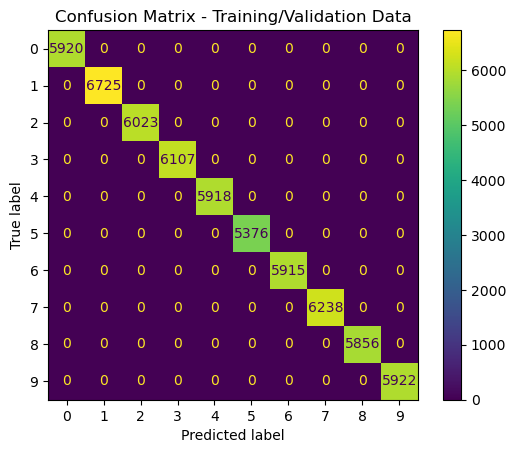

In [22]:
cm_train_val = confusion_matrix(y_train_val, y_train_val_pred)
cm_train_val_display = ConfusionMatrixDisplay(confusion_matrix=cm_train_val, display_labels=voting_clf_soft.classes_)
cm_train_val_display.plot(cmap=plt.cm.viridis)
plt.title("Confusion Matrix - Training/Validation Data")
plt.show()

In [13]:
y_test_pred = voting_clf_soft.predict(X_test_large_scaled)
final_score = accuracy_score(y_test, y_test_pred)
print(final_score)

0.9736


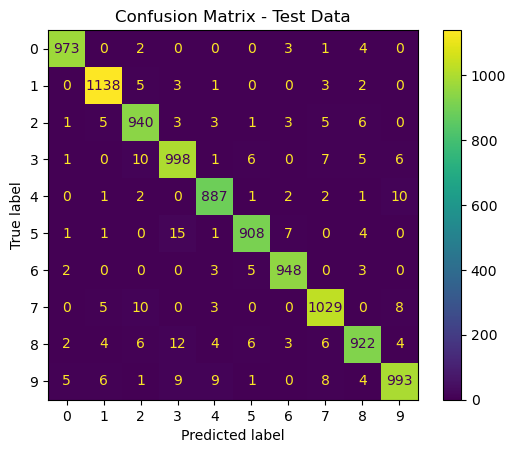

In [24]:
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test_display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=voting_clf_soft.classes_)
cm_test_display.plot(cmap=plt.cm.viridis)
plt.title("Confusion Matrix - Test Data")
plt.show()


In [15]:
#Saving final model
joblib.dump(voting_clf_soft, 'models/final_model/voting_soft.joblib')

['models/final_model/voting_soft.joblib']

In [11]:
#Saving Scaler
joblib.dump(scaler, 'scaler/standard_scaler.joblib')

['scaler/standard_scaler.joblib']